In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, Binarizer

from feature_engine.imputation import AddMissingIndicator, MeanMedianImputer, CategoricalImputer
from feature_engine.encoding import RareLabelEncoder, OrdinalEncoder
from feature_engine.transformation import LogTransformer
from feature_engine.selection import DropFeatures
from feature_engine.wrappers import SklearnTransformerWrapper

import myPreprocessors as mypp #nuestra librerías de transformaciones.

import joblib

#### 1. Se carga el carga la información y se crea un Dataframe

In [3]:
dataTrain = pd.read_csv("train.csv")
dataTrain.head()

,id,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,9744,-121.65,36.77,15,2191,358.0,1150,330,4.7969,227500.0,<1H OCEAN
1,13893,-116.27,34.13,37,452,109.0,184,59,3.7292,65800.0,INLAND
2,18277,-122.07,37.34,35,1172,184.0,512,175,7.3561,500001.0,<1H OCEAN
3,16176,-122.39,37.74,52,126,24.0,37,27,10.2264,225000.0,NEAR BAY
4,8843,-118.38,34.09,28,4001,1352.0,1799,1220,2.5784,272900.0,<1H OCEAN


In [4]:
#Determinación de tipo de datos del dataframe
dataTrain.dtypes

id                      int64
longitude             float64
latitude              float64
housing_median_age      int64
total_rooms             int64
total_bedrooms        float64
population              int64
households              int64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

#### 3. Determinando Nulos 

In [5]:
#Determine que columnas poseen faltantes (NA o Nulos)
columnas_nulos= [col for col in dataTrain.columns if(dataTrain[col].isnull().mean()>0)]
columnas_nulos

['total_bedrooms']

In [6]:
#Determinación de la porcion de faltantes en las columna de Total bedrooms
dataTrain['total_bedrooms'].isnull().mean()

0.009482937634110887

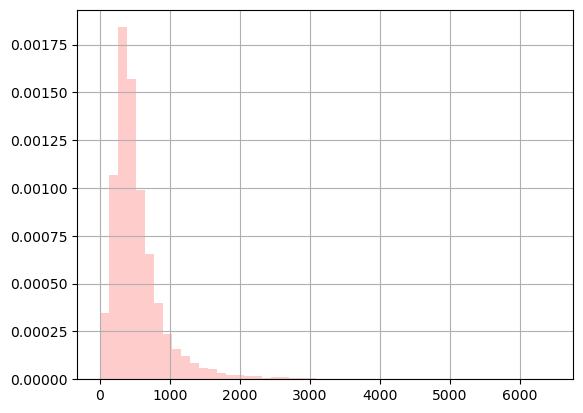

In [7]:
#Con la proporción de faltantes se determina gráfico de Barras
dataTrain['total_bedrooms'].hist(bins=50, density=True, color='red', alpha=0.2)
plt.show()

#### 2. Train Test Split para Entrenamiento y Prueba

In [8]:
#División de conjunto de datos aprendizaje automatico y objetivo a predecir, se establece el 30% del conjunto
X_train, X_test, y_train, y_test = train_test_split(
    dataTrain.drop(['id', 'median_house_value'], axis=1),
    dataTrain['median_house_value'],
    test_size=0.3,
    random_state=2022)

#### 3. Configuración del Pipeline

In [9]:
#Imputación de variables numéricas
NUMERICAL_VARS_WITH_NA = ['total_bedrooms']

#Variables para codificación por frecuencia (no ordinal)
CATEGORICAL_VARS = ['ocean_proximity']

#Variables a utilzar en el entrenamiento
FEATURES = [
    'longitude',
    'latitude',             
    'housing_median_age',     
    'total_rooms',             
    'total_bedrooms',    
    'population',           
    'households',      
    'median_income',       
    'ocean_proximity',     
]

In [10]:
#Selección de conjunto de datos de entrenamiento 
X_train = X_train[FEATURES]

In [11]:
#Transformación y Reducción de Sesgo y mayor precisión del modelo 
y_train = np.log(y_train)
y_test = np.log(y_test)

#### 4. Construcción del Pipeline

In [12]:
housePrice_pipeline_v062023 = Pipeline([
    
    #=========== IMPUTACIONES ===============
    
    #1. Indicador faltane en variables numericas para imputación
    ('missing_indicator_numeric',
        AddMissingIndicator(variables=NUMERICAL_VARS_WITH_NA)
    ),
    
    #2. Imputación de variables numéricas
    ('mean_imputation',
        MeanMedianImputer(imputation_method='mean', variables=NUMERICAL_VARS_WITH_NA)
    ),

#============= CODIFICACIÓN DE VARIABLES CATEGORICAS NOMINALES ==================
    ('rare_label_encoder',
        RareLabelEncoder(n_categories=1, tol=0.01, variables=CATEGORICAL_VARS)
    ),
    
    ('categorical_encoder',
        OrdinalEncoder(encoding_method='ordered', variables=CATEGORICAL_VARS)
    ),

     #=============== SCALER ============
    ('scaler',
        MinMaxScaler()
    ),
    
    ('modelo_lasso', 
         Lasso(alpha=0.01, random_state=2022)
    )
])

In [13]:
#Ajustando el modelo, utilizando variables de entrenamiento
housePrice_pipeline_v062023.fit(X_train, y_train)

Pipeline(steps=[('missing_indicator_numeric',
                 AddMissingIndicator(variables=['total_bedrooms'])),
                ('mean_imputation',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['total_bedrooms'])),
                ('rare_label_encoder',
                 RareLabelEncoder(n_categories=1, tol=0.01,
                                  variables=['ocean_proximity'])),
                ('categorical_encoder',
                 OrdinalEncoder(variables=['ocean_proximity'])),
                ('scaler', MinMaxScaler()),
                ('modelo_lasso', Lasso(alpha=0.01, random_state=2022))])

In [14]:
#Selección de Caracteristicas 
X_test = X_test[FEATURES]

In [15]:
#Realización de predicciones sobre el subconjunto de datos 
preds = housePrice_pipeline_v062023.predict(X_test)

In [16]:
#Calculo del error cuadratico medio 
rmseTest = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(preds)))
rmseTest

86077.02825053826

In [17]:
#Calculo de precios de venta mínimo y máximo 
np.min(np.exp(y_train)), np.max(np.exp(y_train))

(14999.00000000001, 500000.99999999977)

In [18]:
#Calculo del RMSE normalizado
rmseTest / (np.max(np.exp(y_train)) - np.min(np.exp(y_train)))

0.17747767689728766

In [19]:
#Guardar el pipeline para uso en producción.
joblib.dump(housePrice_pipeline_v062023, 'housePrice_pipeline_v062023.pkl')

['housePrice_pipeline_v062023.pkl']

In [20]:
#Guardar la variable para uso en producción.
joblib.dump(FEATURES, 'FEATURES.pkl')

['FEATURES.pkl']